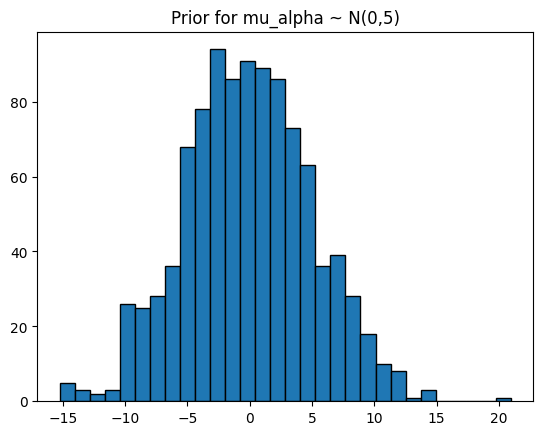

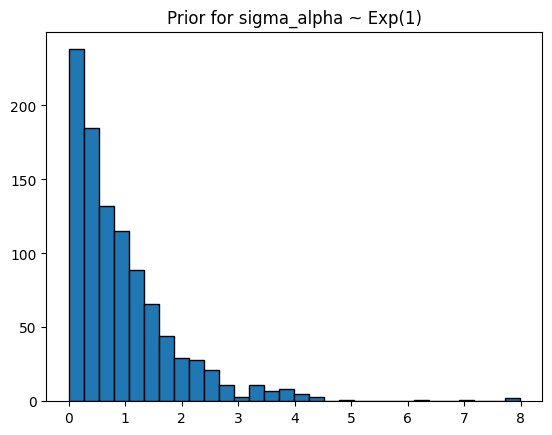

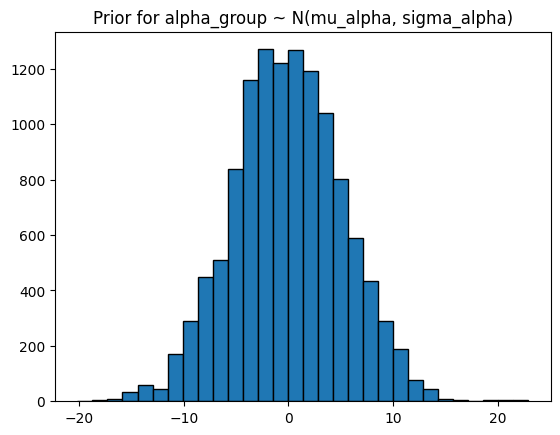

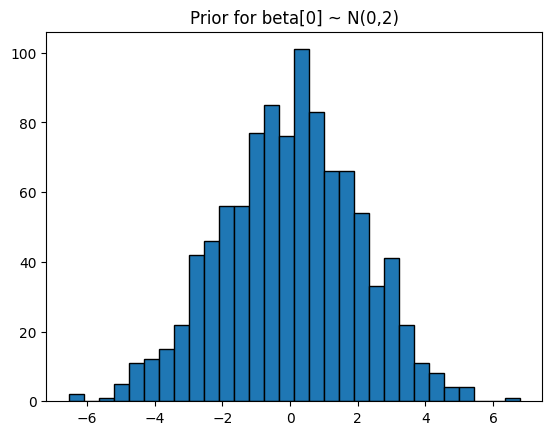

17:15:14 - cmdstanpy - INFO - compiling stan file /workspace/model2_ppc.stan to exe file /workspace/model2_ppc
17:15:25 - cmdstanpy - INFO - compiled model executable: /workspace/model2_ppc


ValueError: Must specify iter_warmup > 0 when adapt_engaged=True.

In [ ]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from cmdstanpy import CmdStanModel

# === Wczytanie danych ===
X, y, purpose = joblib.load("processed_data.pkl")

if hasattr(X, 'toarray'):
    X = X.toarray()

X = X.astype(np.float32)
y = y.astype(np.int32)

# === Grupy (np. 'purpose') jako indeksy 1...G ===
le = LabelEncoder()
group_id = le.fit_transform(purpose) + 1  # Stan uses 1-based indexing
G = len(le.classes_)
N, K = X.shape

stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist(),
    "G": G,
    "group_id": group_id.tolist()
}

# === PRIOR PREDICTIVE CHECK – PARAMETRY (NumPy) ===
n_samples = 1000
mu_alpha_samples = np.random.normal(0, 5, n_samples)
sigma_alpha_samples = np.random.exponential(1, n_samples)

alpha_group_samples = np.array([
    np.random.normal(mu_alpha_samples[i], sigma_alpha_samples[i], G)
    for i in range(n_samples)
])
beta_samples = np.random.normal(0, 2, (n_samples, K))

# === Histogramy priorytetów ===
plt.hist(mu_alpha_samples, bins=30, edgecolor='k')
plt.title("Prior for mu_alpha ~ N(0,5)")
plt.show()

plt.hist(sigma_alpha_samples, bins=30, edgecolor='k')
plt.title("Prior for sigma_alpha ~ Exp(1)")
plt.show()

plt.hist(alpha_group_samples.flatten(), bins=30, edgecolor='k')
plt.title("Prior for alpha_group ~ N(mu_alpha, sigma_alpha)")
plt.show()

plt.hist(beta_samples[:, 0], bins=30, edgecolor='k')
plt.title("Prior for beta[0] ~ N(0,2)")
plt.show()

# === PRIOR PREDICTIVE CHECK – DANE (Stan) ===
ppc_model = CmdStanModel(stan_file="model2_ppc.stan")
ppc_fit = ppc_model.sample(
    data={"N": N, "K": K, "X": X.tolist(), "G": G, "group_id": group_id.tolist()},
    chains=1,
    iter_sampling=1000,
    iter_warmup=1,
    fixed_param=True,
    seed=42
)

ppc_df = ppc_fit.draws_pd()
y_sim_matrix = ppc_df[[col for col in ppc_df.columns if "y_sim" in col]].values
mean_simulated_defaults = y_sim_matrix.mean(axis=1)

plt.hist(mean_simulated_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive (Stan): mean(defaults) for model2")
plt.xlabel("Średnia liczba defaultów")
plt.ylabel("Liczba symulacji")
plt.show()

# === DOPASOWANIE MODELU ===
model = CmdStanModel(stan_file="model2.stan")
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)

idata = az.from_cmdstanpy(posterior=fit)

# === Traceplot i Posterior ===
az.plot_trace(idata, var_names=["mu_alpha", "sigma_alpha", "beta"])
plt.tight_layout()
plt.show()

az.plot_posterior(idata, var_names=["mu_alpha", "sigma_alpha", "beta"],
                  coords={"beta_dim_0": list(range(min(5, K)))})
plt.tight_layout()
plt.show()

# === Predykcja: średnie parametry z posteriora ===
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
mu_alpha = posterior_means["mu_alpha"].values.item()
beta_mean = posterior_means["beta"].values
alpha_group = posterior_means["alpha_group"].values.flatten()

logits = np.array([
    alpha_group[g - 1] + X[i] @ beta_mean for i, g in enumerate(group_id)
])
probs = 1 / (1 + np.exp(-logits))

# === Histogram przewidywanych prawdopodobieństw defaultu ===
plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład P(default) – model 2 (efekty grupowe)")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()